## Physics Informed Neural Networks to Approximate Solution of PDEs

In [ ]:
from pinn import NNAnsatz, PINNTrainer
import matplotlib.pyplot as plt
import numpy as np

import torch
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)

# Basic theory and problem setup
Consider the one-dimensional heat equation:

$$
u_t(t, x) = u_{xx}(t, x), \quad t\in[0,T], ~x\in [-1,1]
$$


with zero Dirichlet boundary conditions

$$
u_b(t, -1)=u_b(t,1)=0,
$$

and initial condition

$$
u(x, 0) = u_0(x) = - \sin(\pi x)
$$

We want to obtain an approximate solution of the heat equation $u : [0,T]\times[-1,1] \mapsto \mathbb{R}$ with physics informed neural networks (PINNs).

To do so, we approximate the underlying solution with a feedforward dense neural network with tunable parameters $\theta$:

$$
u_\theta(t,x) \approx u(t,x)
$$
Define the following residuals:

   - Interior residual given by,

   $$r_{int,\theta}(t, x):=  u_{\theta, t}(x,t) - u_{\theta, xx}(x,t), \quad \forall ~t \in [0,T],~ x \in [-1,1].$$
   
        
      
        
   - Spatial boundary residual given by,
   
        $$r_{sb,\theta}(t,-1):= u_{\theta}(t,-1)- u_b(t,-1), \quad r_{sb,\theta}(t,1):= u_{\theta}(t,1)- u_b(t,1), \quad \forall t \in (0,T].$$
        
   - Temporal boundary residual given by,
   
        $$r_{tb,\theta}(x):= u_{\theta}(x,0) - u_0(x), \quad \forall x \in [-1,1].$$

and compute the corresponding loss functions:

$$
L_{int}(\theta) = \int_{[0,T]\times[-1,1]}r_{int,\theta}^2(t, x) dtdx, \quad
L_{sb}(\theta) = \int_{[0,T]}r_{sb,\theta}^2(t,-1) dt + \int_{[0,T]}r_{sb,\theta}^2(t,1)dt, \quad
L_{tb}(\theta) = \int_{[-1,1]}r_{tb,\theta}^2(x) dx
$$

The loss functions include integrals that can be approximated by suitable quadrature rule. We use quasi Monte-Carlo and accordingly define the following training sets

$$
S_{int} =\{y_n\}, \quad 1 \leq n \leq N_{int},\quad y_n = (x,t)_n \in D_T,
$$

$$
S_{sb, -1} =\{t_n, u_b(t_n,-1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{sb, 1} =\{t_n, u_b(t_n,1) \}, \quad1 \leq n \leq N_{sb}, t_n \in [0,T],
$$

$$
S_{tb}=\{x_n, u_0(x_n)\}\quad  1 \leq n \leq N_{tb}, x_n \in [-1,1].
$$

with the training inputs points corresponding to low-discrepancy Sobol sequences.

$$
L_{int}(\theta) = \frac{1}{N_{int}}\sum_{i=1}^{N_{int}}r_{int,\theta}^2(y_n), \quad
L_{sb}(\theta) = \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,-1) + \frac{1}{N_{sb}}\sum_{i=1}^{N_{sb}}r_{sb,\theta}^2(t_n,1), \quad
L_{tb}(\theta) = \frac{1}{N_{tb}}\sum_{i=1}^{N_{tb}}r_{tb,\theta}^2(x_n)
$$

and solve the following minimization problem

$$
\theta^\ast = argmin_{\theta} \Big(L_{int}(\theta) + \lambda_u L_u(\theta)\Big)
$$

with

$$
L_u(\theta) = L_{tb}(\theta) + L_{sb}(\theta)
$$



# Your task: Solve the $1D$ heat equation using PINNs

You will have to implement the following

*  `NNAnsatz` a neural net approximator for the solution of the heat equation.
*   Missing functionality in the `PINNTrainer`, namely:
    *   `PINNTrainer.compute_pde_residual` to compute the PDE loss on your predictions.
    *   `PINNTrainer.compute_loss` to aggregate all the residuals into a single weighted loss.

Use `torch.autograd.grad` to compute gradients, second derivatives -- some basic examples can be found [here](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html). Make sure the gradients you compute are attached to the computational graph so that you can backpropagate through them.


Follow the `TODOs`.












# Setting up the training data

Just familiarize yourself with how wo generate collocation points for the different types of residuals.

In [ ]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi * x).

n_int = 256
n_sb = 64
n_tb = 64

pinn = PINNTrainer(n_int, n_sb, n_tb)

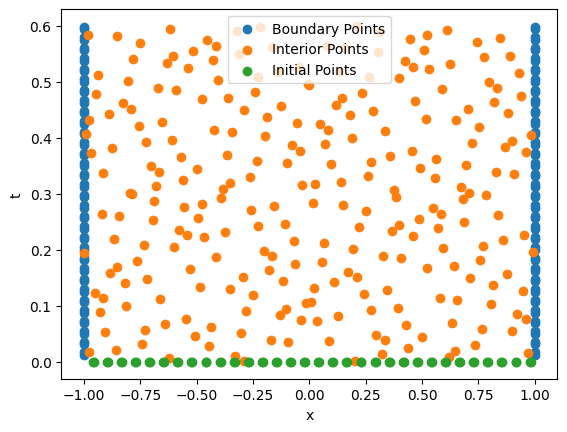

In [ ]:
# Plot the input training points.
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

plt.scatter(
    input_sb_[:, 1].detach().numpy(),
    input_sb_[:, 0].detach().numpy(),
    label="Boundary Points")
plt.scatter(
    input_int_[:, 1].detach().numpy(),
    input_int_[:, 0].detach().numpy(),
    label="Interior Points")
plt.scatter(
    input_tb_[:, 1].detach().numpy(),
    input_tb_[:, 0].detach().numpy(),
    label="Initial Points")

plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

# Training

Train your network and ensure your loss is low, and that your predictions are qualitatively similar to the true solution (plots should look similar).

In [ ]:
hist = pinn.fit(num_epochs=1, verbose=True)

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

In [ ]:
pinn.plot()